In [6]:
#!pip install imutils
#!pip install opencv-python
#!pip install seaborn

In [60]:
import cv2
import os, glob
import time
import numpy as np
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization, Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 20
img_size = 224
INP_SIZE = (224,224,3)

In [61]:
                        #######################
                        # Class_a - covid19   #
                        # Class_b - normal    #
                        # Class_c - pneumonia #
                        #######################

train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False,
        fill_mode="constant") 

test_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False,
        fill_mode="constant")

train_generator = train_datagen.flow_from_directory(
        'H:/Projekty/Dane/COVID-19 Radiography Database/cropped/train',
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'H:/Projekty/Dane/COVID-19 Radiography Database/cropped/validation',
        target_size=(img_size, img_size),
        batch_size=16,
        class_mode='categorical')


Found 2565 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


In [62]:
import time 
def time_elapsed(sec):
  h = int(sec/3600)
  m = int(sec/60)
  s = sec % 60
  return "{}h:{:>02}m:{:>05.2f}s".format(h,m,s)

In [76]:
model = VGG16(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE))
i = 0
for layer in model.layers:
    if i>15:
        layer.trainable = True
    else:
        layer.trainable = False
    i = i+1
        # top layer for shaping output    
headModel = model.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=model.input, outputs=headModel)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [77]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, verbose=1,factor=0.3, min_lr=0.00000198)
monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, 
      patience=30, mode='auto', restore_best_weights=True)

history = model.fit(train_generator ,
                    epochs = 100 , validation_data=validation_generator,
                    callbacks = [learning_rate_reduction,monitor])

Train for 81 steps, validate for 6 steps
Epoch 1/100
81/81 [==============================] - 31s 389ms/step - loss: 0.7981 - accuracy: 0.6288 - val_loss: 1.5508 - val_accuracy: 0.4074
Epoch 2/100
81/81 [==============================] - 30s 370ms/step - loss: 0.6626 - accuracy: 0.7232 - val_loss: 1.1900 - val_accuracy: 0.5679
Epoch 3/100
81/81 [==============================] - 30s 368ms/step - loss: 0.5774 - accuracy: 0.7591 - val_loss: 0.9008 - val_accuracy: 0.4815
Epoch 4/100
80/81 [============================>.] - ETA: 0s - loss: 0.5324 - accuracy: 0.7793
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
81/81 [==============================] - 30s 368ms/step - loss: 0.5306 - accuracy: 0.7793 - val_loss: 0.9293 - val_accuracy: 0.5185
Epoch 5/100
81/81 [==============================] - 30s 368ms/step - loss: 0.4794 - accuracy: 0.7910 - val_loss: 0.7359 - val_accuracy: 0.6420
Epoch 6/100
81/81 [==============================] - 30s 367ms/step - loss: 

81/81 [==============================] - 30s 366ms/step - loss: 0.2763 - accuracy: 0.8990 - val_loss: 0.2182 - val_accuracy: 0.9259
Epoch 51/100
81/81 [==============================] - 30s 367ms/step - loss: 0.2881 - accuracy: 0.8924 - val_loss: 0.2834 - val_accuracy: 0.9012
Epoch 52/100
81/81 [==============================] - 30s 367ms/step - loss: 0.3008 - accuracy: 0.8838 - val_loss: 0.2296 - val_accuracy: 0.9012
Epoch 53/100
81/81 [==============================] - 30s 367ms/step - loss: 0.2910 - accuracy: 0.8834 - val_loss: 0.2409 - val_accuracy: 0.9136
Epoch 54/100
81/81 [==============================] - 30s 366ms/step - loss: 0.2938 - accuracy: 0.8873 - val_loss: 0.3509 - val_accuracy: 0.8765
Epoch 55/100
81/81 [==============================] - 30s 368ms/step - loss: 0.2722 - accuracy: 0.8990 - val_loss: 0.2335 - val_accuracy: 0.9259


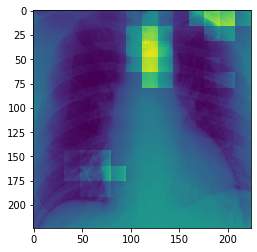

 The pattient has Covid_19 with probability of 99.66766834259033 %


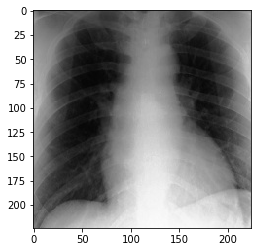

In [193]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models
import tensorflow as tf
import numpy as np

image_size = 224

# Load pre-trained Keras model and the image to classify

image = cv2.imread('H:/Projekty/Dane/COVID-19 Radiography Database/cropped/validation/class_a/24.jpg') 
#image = np.random.random((image_size, image_size, 3))
x_test = np.array(image) / 255
x_test = x_test.reshape(-1, img_size, img_size,3)
x_test = x_test.astype('float32')

dim = (image_size, image_size)
# resize image
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
img_tensor = preprocessing.image.img_to_array(image)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

conv_layer = model.get_layer("block5_conv3")
heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat
heatmap = heatmap[0,:,:]
heatmap = cv2.resize(heatmap, dim, interpolation = cv2.INTER_AREA)
for i in range(image_size):
    for j in range(image_size): 
        if heatmap[i,j]<=0.4:
            heatmap[i,j] = 0.3


prediction = model.predict(x_test)
pred = np.argmax(prediction,axis=1)
probability = prediction.max()
result = 'unknown'
if pred[0] == 0:
    result = 'Covid_19'
if pred[0] == 1:
    result = 'Healthy Lungs!'
if pred[0] == 2:
    result = 'Pneumonia'
    
test=image[:,:,0]*heatmap    
plt.imshow(test)
plt.show()
plt.imshow(image)
print(f' The pattient has {result} with probability of {probability*100} %')

100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1592.44it/s]


Accuracy is: 0.9259259259259259


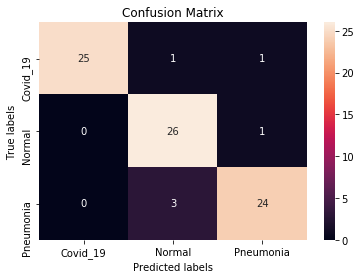

In [182]:
import os
import sys
import numpy as np
import cv2
import lungs_finder as lf
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt   

DATA_PATH_array = ['H:/Projekty/Dane/COVID-19 Radiography Database/cropped/validation/class_a',
                   'H:/Projekty/Dane/COVID-19 Radiography Database/cropped/validation/class_b',
                   'H:/Projekty/Dane/COVID-19 Radiography Database/cropped/validation/class_c']
x_test = []
y_test=np.zeros((3*27,3))
y_test[:27,0] = 1
y_test[27:54,1] = 1
y_test[54:82,2] = 1
y_test

for DATA_PATH in DATA_PATH_array:
    j = 0
    for filename in tqdm(os.listdir(DATA_PATH)):
        path = os.path.join(DATA_PATH,filename)
        image = cv2.imread(path)
        x_test.append(image)

x_test = np.array(x_test) / 255
x_test = x_test.reshape(-1, img_size, img_size,3)
x_test = x_test.astype('float32')
y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)
y_test = np.reshape(y_test,(81,1))
y_pred = np.reshape(y_pred,(81,1))
score = accuracy_score(y_test, y_pred)
print(f'Accuracy is: {score}')

y_test_labeled = []
y_pred_labeled = []

for i in range(len(y_test)):
    if y_test[i] == 0:
        y_test_labeled.append('Covid_19')
    if y_test[i] == 1:
        y_test_labeled.append('Normal')
    if y_test[i] == 2:
        y_test_labeled.append('Pneumonia')
    if y_pred[i] == 0:
        y_pred_labeled.append('Covid_19')
    if y_pred[i] == 1:
        y_pred_labeled.append('Normal')
    if y_pred[i] == 2:
        y_pred_labeled.append('Pneumonia')
    
labels = ['Covid_19', 'Normal', 'Pneumonia']
cm = confusion_matrix(y_test_labeled, y_pred_labeled, labels )
  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


In [194]:
os.system('jupyter nbconvert --to html Chest_X_ray.ipynb')

0